 # Lesson Bayes: Introduction

In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

# Lesson: Bayes Rule
The idea and mathematical formula behind it all

Also called
* Bayes Law
* Bayes Theorem

# What we'll cover in this lesson
* The formal definition of Bayes Theorem
* What each term in Bayes Theorem means
* The intuition behind each of the terms
* Why we care about 3 of those terms and not 1 of them


 # Lesson Bayes: The Philosophy and Equation
 3 things we care about, one we don't

In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

In [12]:
%matplotlib inline
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)

# Two websites: Which one is better?
If we deploy two websites, which one will generate *more conversions*?
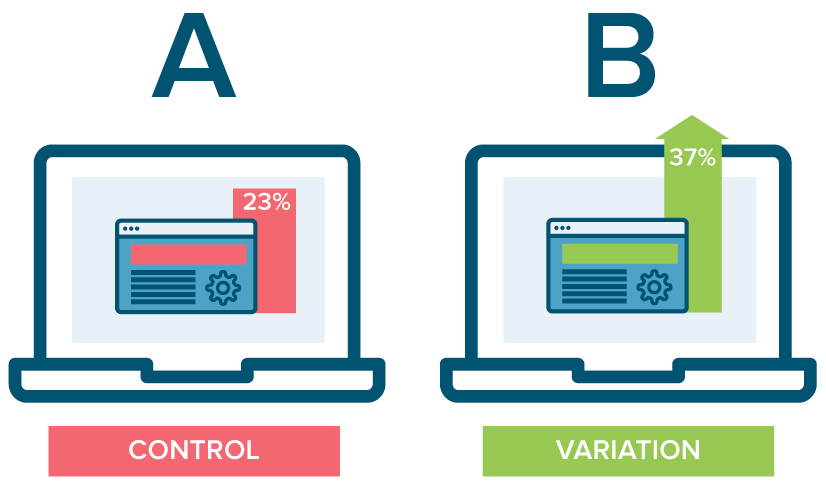


# Two websites: Which one is better (using distributions)?

If we model 100 people visiting a website using a *binomial distribution* what is the most plausible *distribution* of *p(conversion)*?


# Two websites: Which one is better using distributions and expert knowledge?

We want to

* use prior knowledge from similar launches
* model people visiting a website as a *binomial distribution*
* understand what is the most plausible *distribution* of *p(conversion)*?


# Bayes Rule: The mathematical formula 

Below is the mathematical formula that defines Bayes Rule with each component labeled.

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

$\boldsymbol{Y}$ is the observed data and $\theta$ is our parameters




# Bayes Rule: Building an intuition
While we won't be using the formula directly breaking each piece down will help our intuition

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$



# Bayes Rule: Posterior Distribution

$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

On the left is the *posterior distribution* $p(\boldsymbol{\theta} \mid \boldsymbol{Y})$.  
The posterior distribution represents the learnings from the world which enables us to perform *inference*.

In our A/B test the posterior distribution represents our beliefs *after* seeing the observed samples from the test

# Bayes Rule: Prior  Distribution
$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

On the top right is the *prior distribution* $p(\boldsymbol{\theta})$ 

The prior distribution describes the plausibility of parameters before seeing any data. 
This is what lets us express expert knowledge if we choose to do so.

In our A/B test we may know values above an 80% conversion rate are essentially impossible. We can choose to express that expert knowledge in our prior

# Bayes Rule: Likelihood
$$ 
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Also on the top right is the *likelihood* $p(\boldsymbol{Y} \mid \boldsymbol{\theta})$ 

The likelihood is the plausibility of data given a parameter.  
This is what incorporates the data into the posterior calculation.

In our A/B test if 40 out of 100 people convert in our observed sample the likelihood tells us the true conversion rate of 35% is more plausible than a true conversion rate of 90%

# 🤔 Marginal probability of data (and why we don't care)

This is last term is $P(Y)$ at the bottom

We don't need it for three reasons
1. The probability of the data itself is not important, what we care about is the underlying parameter *p(conversion)*
2. It's extremely difficult to calculate for non trivial problems
  * The type of math required to actually figure it out, integrals, can quickly become challenging or even impossible
3. In sampling based Bayes, we don't need it to calculate the posterior distribution

We will ignore this term for the rest of this course for these reasons

# Two websites: Which one is better (in Bayes language)
Reframed in Bayesian language
* the knowledge that 10% to 50% conversion is what we believe *prior* to seeing data is what defines our *prior distribution
* The assumption each visitor has *equal probability* of converting and each visit is *independent* and what we'll observe is a total count is represented in the *likelihood*
    * The observed data will be used in conjunction with the likelihood distribution to calculate, well, the likelihood of the observed data

Thus *posterior* distribution will be a combination of
* our *prior knowledge* 
* our model of *how the world works*
* the *observed data*

all of which will inform which website is better

# Bayes Rule in a picture
We showed this in our introductory lesson. Now you know the mathematics behind it
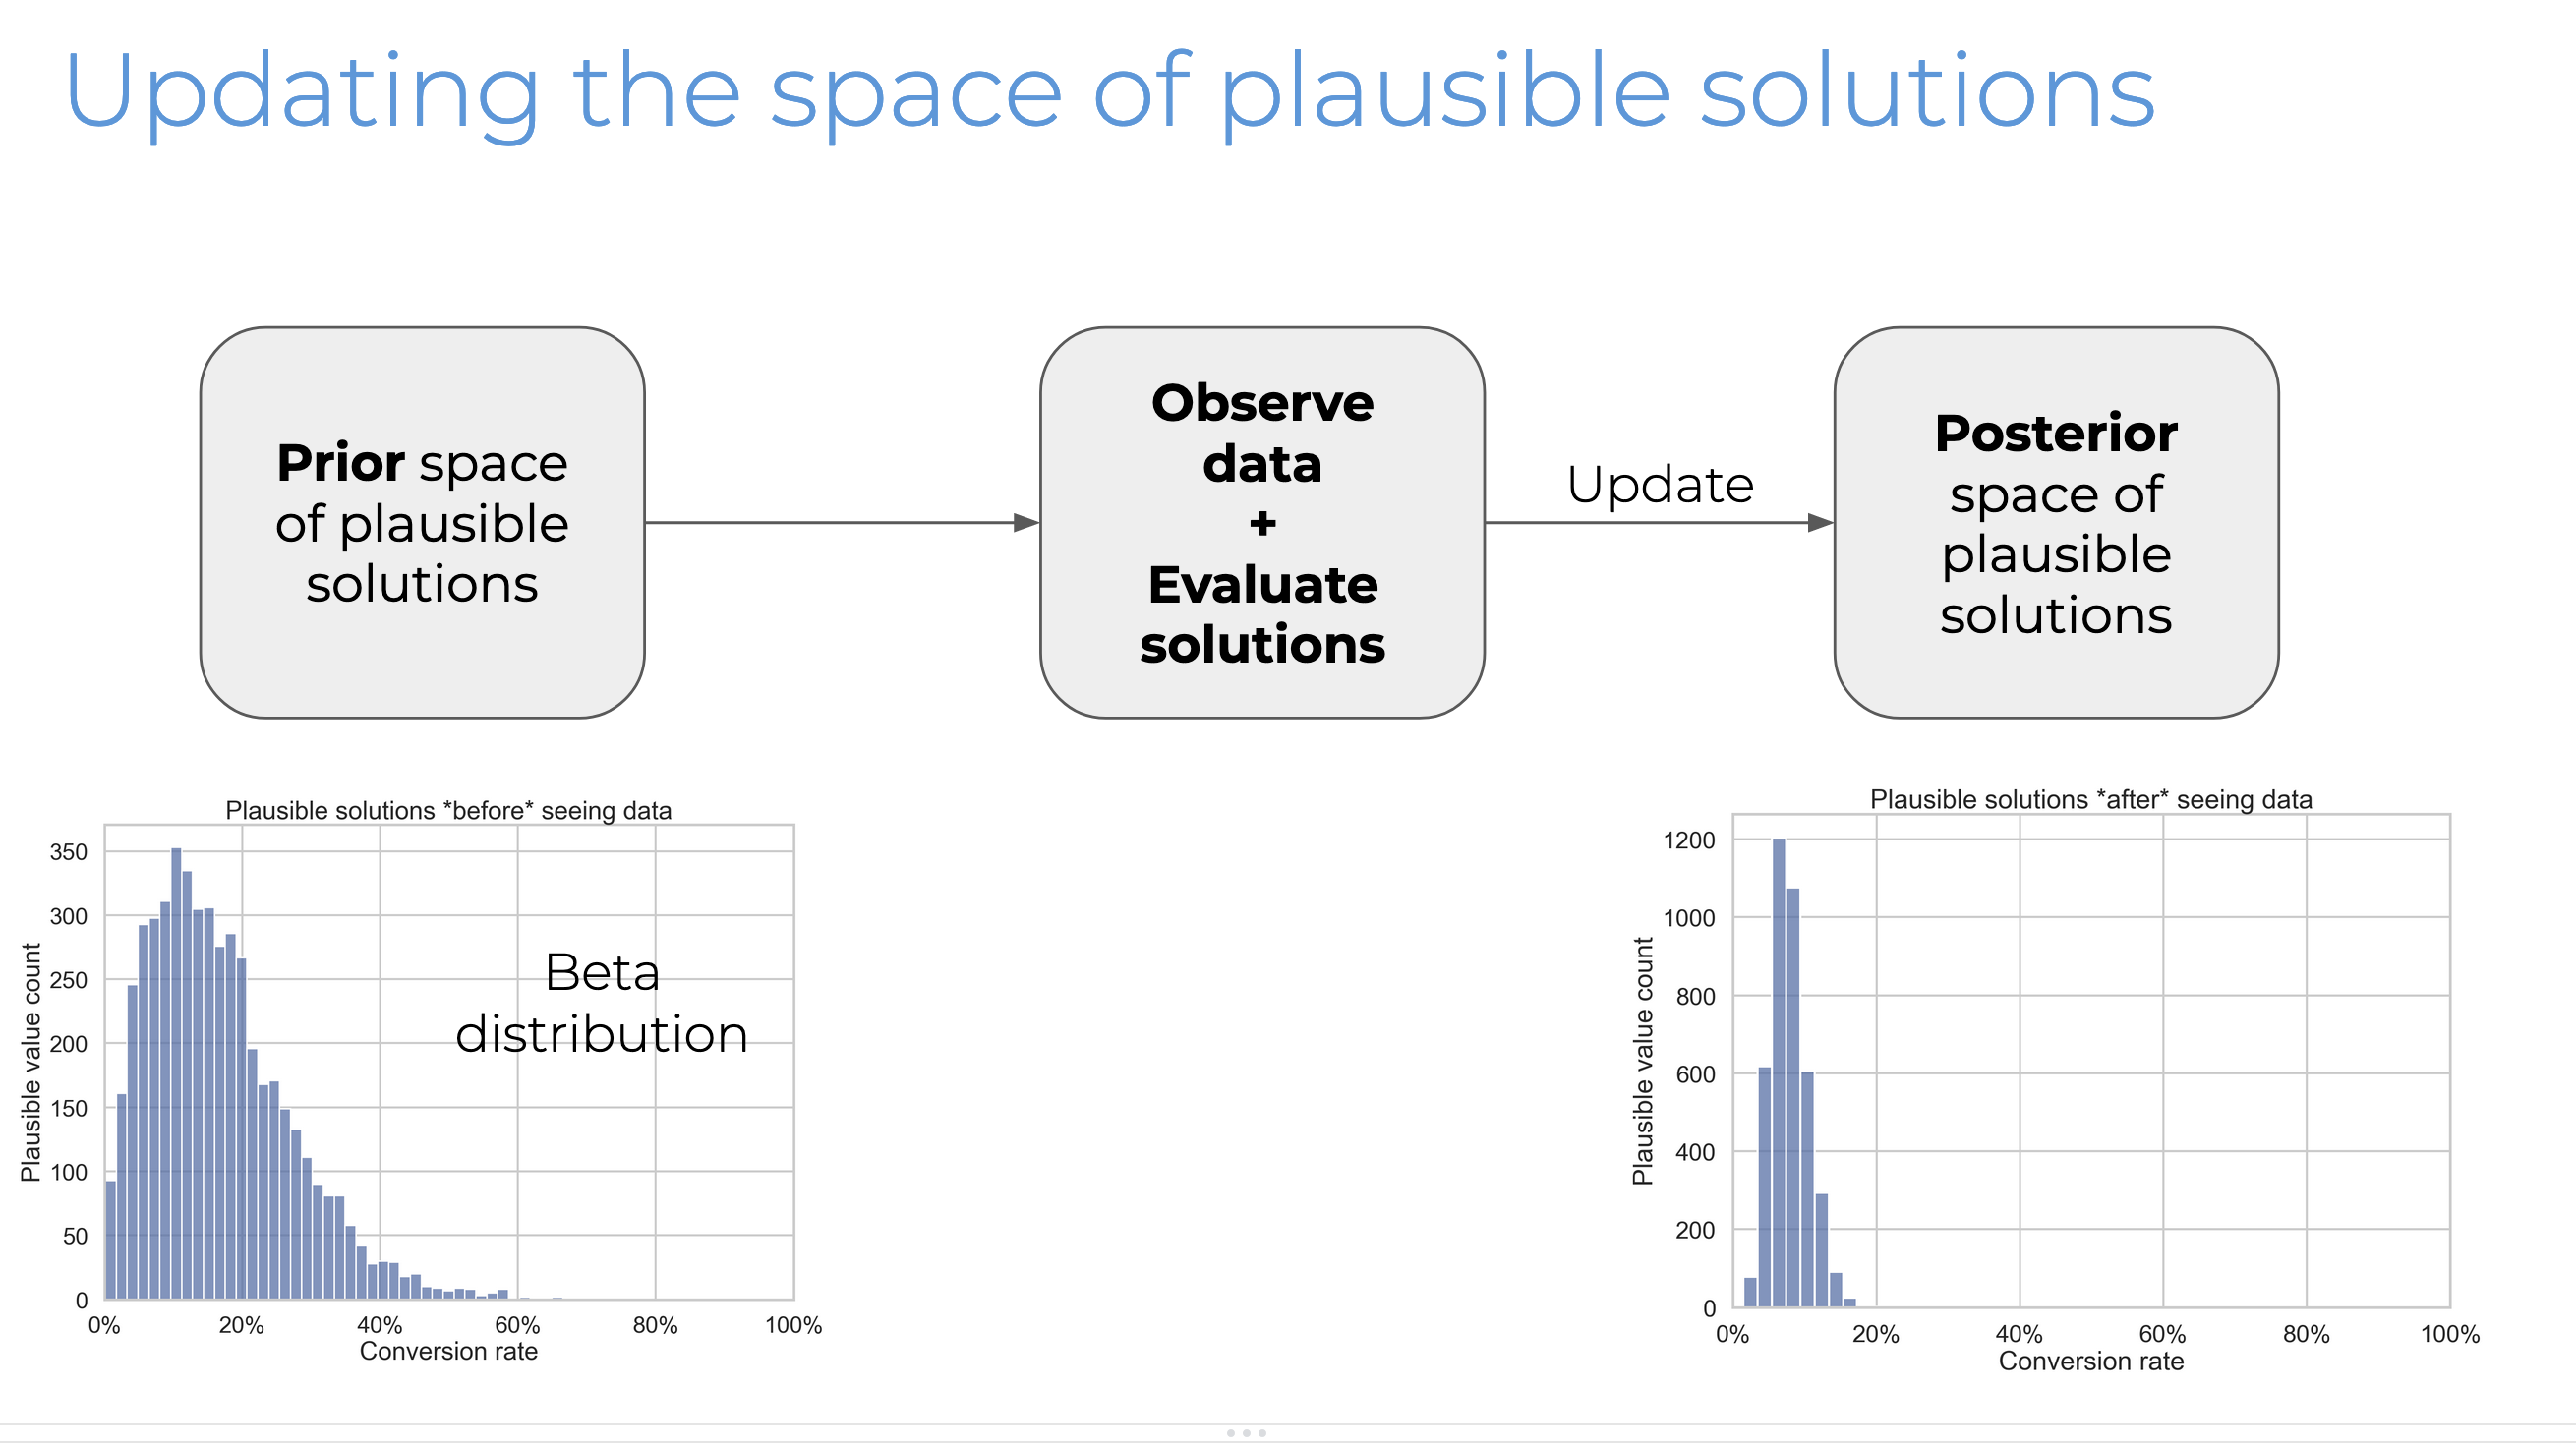

# Section Recap
* Bayes Rule gives us a mathematical framework update our beliefs based on a model, observed data, and our prior knowledge
* Bayes Rule is comprised of 3 major parts
    * Priors 
    * Likelihoods
    * Posterior
* Bayes Rule also has a fourth term *marginal probability of data* that is not needed with sampling based methods and can be safely ignored in this course

# Lesson Bayes: Priors
Expressing plausibility before seeing data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

# A/B Testing: What do we know before we see the data?
Before running the experiment what do we believe the conversion ratio could be?

* Any value between 0% and 100% equally?
* Probably 20% based on past experience?
* Definitely not above 40%?

# Priors distributions can let us express our expert knowledge
Each of these distributions showcase a different belief

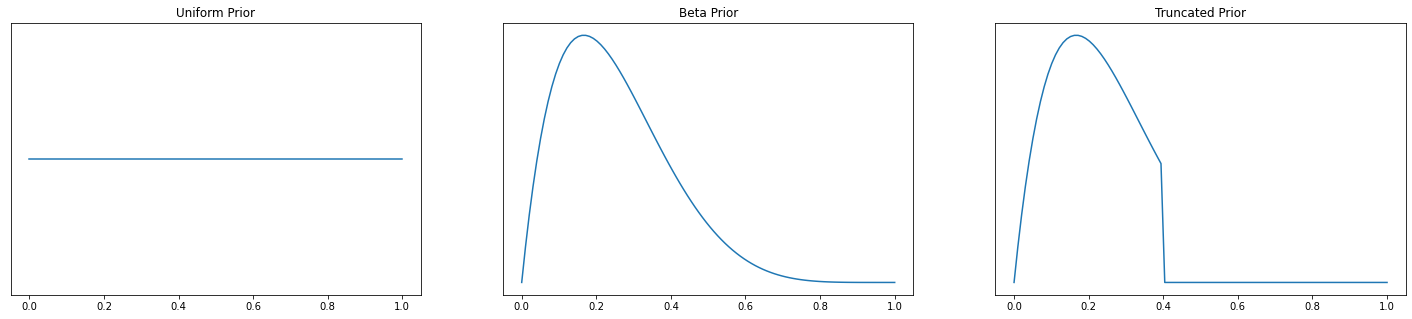

In [2]:
def priors(labels):
    fig, axes = plt.subplots(1, 3, figsize=(25,5))

    x = np.linspace(0,1,100)

    unif = stats.uniform(0,1)
    axes[0].plot(x, unif.pdf(x))
    axes[0].set_title(labels[0])

    beta = stats.beta(2,6)
    axes[1].plot(x, beta.pdf(x))
    axes[1].set_title(labels[1])


    truncated = stats.beta(4,12)
    pdf = beta.pdf(x)
    pdf[x>.4] = 0
    axes[2].plot(x, pdf)
    axes[2].set_title(labels[2])

    for ax in axes:
        ax.set_yticks([])
    return 

labels = ["Uniform Prior", "Beta Prior", "Truncated Prior"]
priors(labels)

# Aren't priors subjective?
Sometimes. Keep in mind all statistics is subjective whether that be
* What p value to use in a freqentist framework
* What outliers to remove
* What methodology to use

# Informative vs Uninformative Prior
You choose the what of plausibility that is conveyed in a prior. 

Some priors convey very differing plausibility, such as the Uniform distribution

In the charts below the other two informative priors contain some information whether that be
* Relative degree of belief
* The range of possibilities

In all cases we are expressing the plausibility of every value *prior* to seeing any data

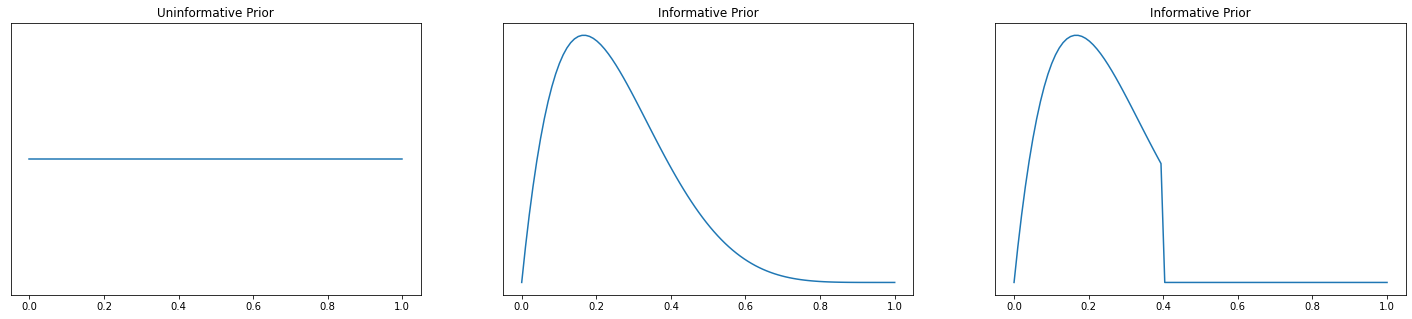

In [3]:
labels = ["Uninformative Prior", "Informative Prior", "Informative Prior"]
priors(labels)

# 🔑  The rationale behind the prior is what's important

You may be now thinking "Well how do I know the right/best/correct prior?" The truth is you won't.

There's a famous quote stating "All models are wrong, some are useful"

When selecting priors the task is not to pick the right prior *independent of any other factor*, but one that you can justify in context with
* the rest of the model
* how your model will be used in reality
* the experience of domain experts

# Priors are a form of regularization
Another benefit of priors is they can be utilized to focus the models on reasonable possibilities and not far flung parameters that happen optimize a metric.

In other words we can use priors to
* Highlight reasonable possible parameters
* Penalize unreasonable possible parameters

For example in the case below if we were using a Bayesian model to estimate the degree of fit of a polynomial, we could choose to put a prior with high beliefs on polynomial degree 2-6, but lesser belief on 0, 1 and greater than 8

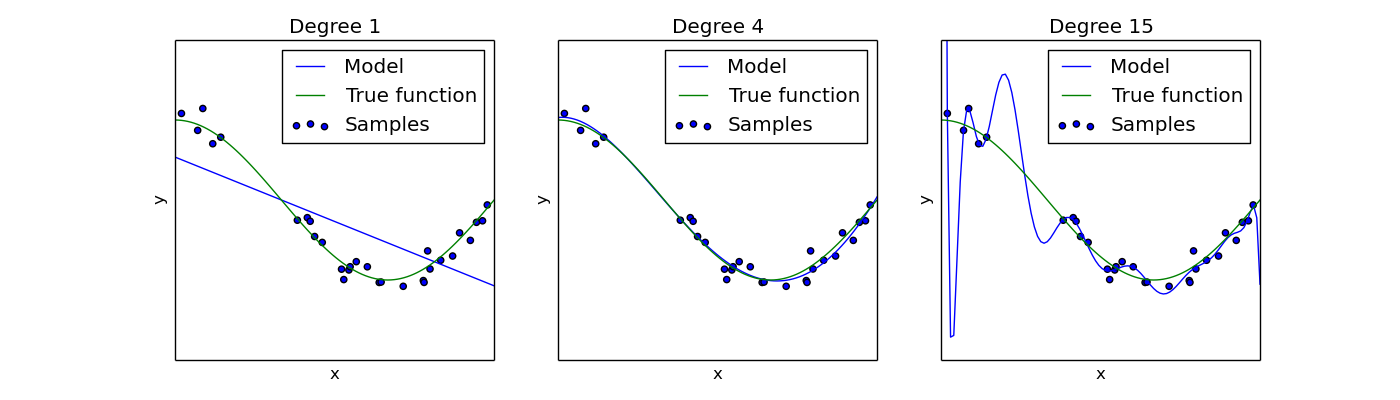
**Source**: scikit-learn documentation

# Section Recap
* Priors distributions express the plausibility of parameters prior to seeing data
* Priors *can*, but do not necessarily, have to be subjective
* When choosing a prior focus on the rationale behind the prior, not picking the "right" prior


# Lesson Bayes: Likelihoods
The plausibility of the data given a parameter

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

# 🙌 What is the likelihood (intuitively)?
For our A/B test example let's say we on variant B we see *100* visits and *85* of them convert.

What is the plausibility that the true conversion rate, p(conversion) is:
* 1%
* 100%
* 80%
* 95%

Pause the video here and rank these from most to least plausible before continuing on

# Intuitively ranking `p(conversion)` values?

1. 80%
2. 95%
3. 1%
4. 100%

Out of 100 visits, 85 converted. That brings us to an *empirical* conversion rate of 85%, but as Bayesians we also want to know the plausibility of all other conversion rates.

Intuitively we know a 100% conversion rate impossible. If even 1 person didn't convert the true conversion rate can't be 100%.

1% is highly implausible but *it is still possible*. It may be that in our sample of 100 we were lucky to get 85, but it's not likely.

Intuition may not be enough to differentiate  80% and 95%, let's show how to calculate likelihood

# Calculating Likelihood
We use the tool of PMFs and PDFs to measure the plausibility of a parameter given data.

For the A/B test we use a binomial likelihood with our observed data, and plug in our parameter to get a number.

In [5]:
num_conversions, num_visitors = 85, 100
possible_true_conversion_rate = .80
binom = stats.binom(p=possible_true_conversion_rate, n=num_visitors)
binom.pmf(num_conversions)

0.0480617937007464

Remember though that the PMF, or PDF, values only mean something relative to each other.

Let's use a handy trick from scipy where we can plug in all four parameter values and calculate the likelihood in one go.

# Calculating Multiple Likelihoods
The results match our intuition. 100% conversion is impossible, given a value of zero, 1% is highly unlikely, and comparing 80% and 95%, 80% is more likely

In [6]:
multiple_possible_true_conversion_rates = [.01, .8, .95, 1]

binom = stats.binom(p=multiple_possible_true_conversion_rates, n=num_visitors)
binom.pmf(num_conversions)

array([2.17885869e-153, 4.80617937e-002, 9.88001628e-005, 0.00000000e+000])

This is great, now we have a way of quantifying the plausibility of the observed data given a parameter.

# Intuition through linear regression  

Plausibility can exist in more than two dimensions. See an example below for a linear regression.

Which line seems the most plausible to you?

Later on in this course we'll show how to use Bayesian tools to answer this questions quickly and easily.

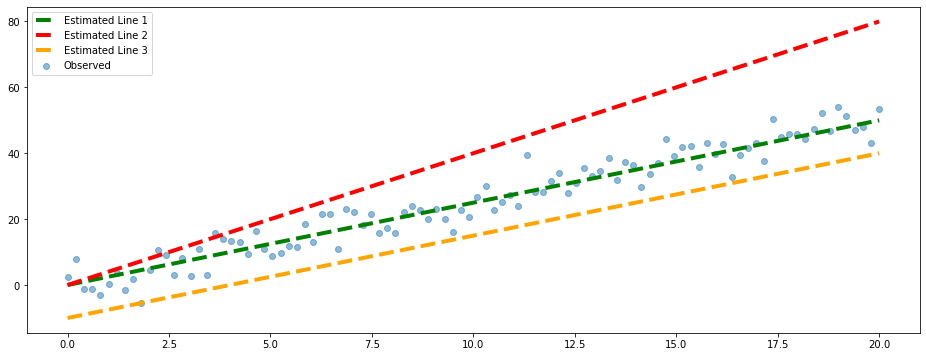

In [4]:
RANDOM_SEED = 8265
np.random.seed(RANDOM_SEED)
x = np.linspace(-0, 20, 100)
slope_true = 2.5

y_obs = x*slope_true + stats.norm(0,4).rvs(100)

fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(x, y_obs, alpha=.5, label="Observed")

lw=4
ax.plot(x, slope_true*x, c="g", lw=lw, ls="--", label="Estimated Line 1" )
ax.plot(x, 4*x, c="r", lw=lw, ls="--", label="Estimated Line 2")
ax.plot(x, (slope_true*x) -10, c="orange", lw=lw, ls="--", label="Estimated Line 3")

plt.legend();

# Section Recap
* Likelihood measures the plausibility of parameters given data
    * It answers the question "Given this observed data what parameters are the most likely to have produced it?"
* Likelihood is measured by the PDF or PMF the data given a fully specified distribution

# Lesson Bayes: Posterior
The coveted distribution that enables *inference*

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import stats

# The fundamental question
If we observe something, what can we infer about the world in general?

Or as statistician would say 

If we have 
1. *observed samples* from the world
2. a *model* of how the world works
3. a *prior* belief

What is our updated belief after seeing our observations? 

It's the posterior distribution

# Calculating the posterior for our A/B Test 
Remember, to calculate a posterior we need
* Prior(s)
* Data
* Likelihood

Let's review what we've seen thus far

## Our Prior
We'll use an informative prior that specifies our belief before we collected information. We believe values close to edges (0% and 100%) as less plausible

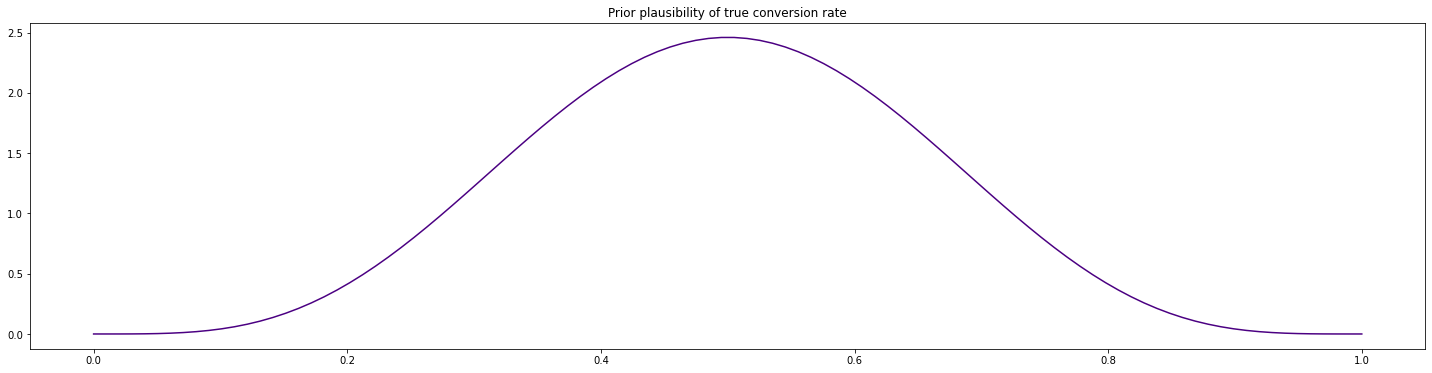

In [2]:
fig, ax = plt.subplots(figsize=(25,6))
possible_p_values = np.linspace(0,1,100)

beta = stats.beta(5,5)
prior = beta.pdf(possible_p_values)
ax.plot(possible_p_values, prior, c="indigo")
ax.set_title("Prior plausibility of true conversion rate");

## The Data
This is fixed, we don't choose data, we just observe it.

Let's say we observed 9 conversions and 1 non conversion

In [3]:
obs = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

## Our Likelihood (and model)
Now we're ready to calculate the likelihood. 

For each possible p value we calculate the relative likelihood that the data could have been produced with that p value

In [4]:
possible_p_values = np.linspace(0,1,100)
likelihood = stats.binom(p=possible_p_values, n=obs.shape[0]).pmf(obs.sum())

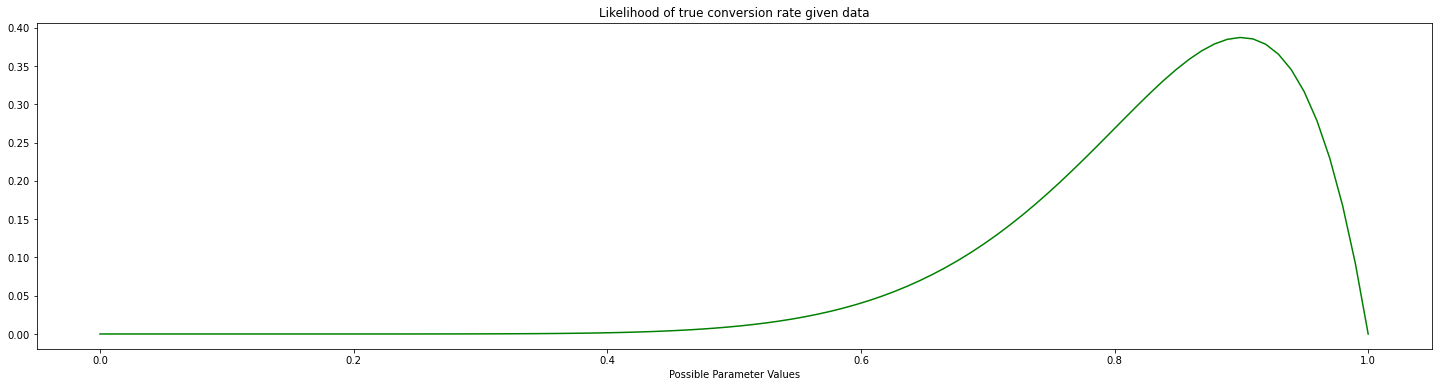

In [5]:
fig, ax = plt.subplots(figsize=(25,6))

ax.plot(possible_p_values,likelihood, c="g")
ax.set_title("Likelihood of true conversion rate given data")
ax.set_xlabel("Possible Parameter Values");

# To get a posterior all we need to do is multiply!
Per the definition of Bayes formula thats all there is to it.

With our prior and likelihood values calculated all we need to do now is multiply across!

In [6]:
posterior = prior * likelihood

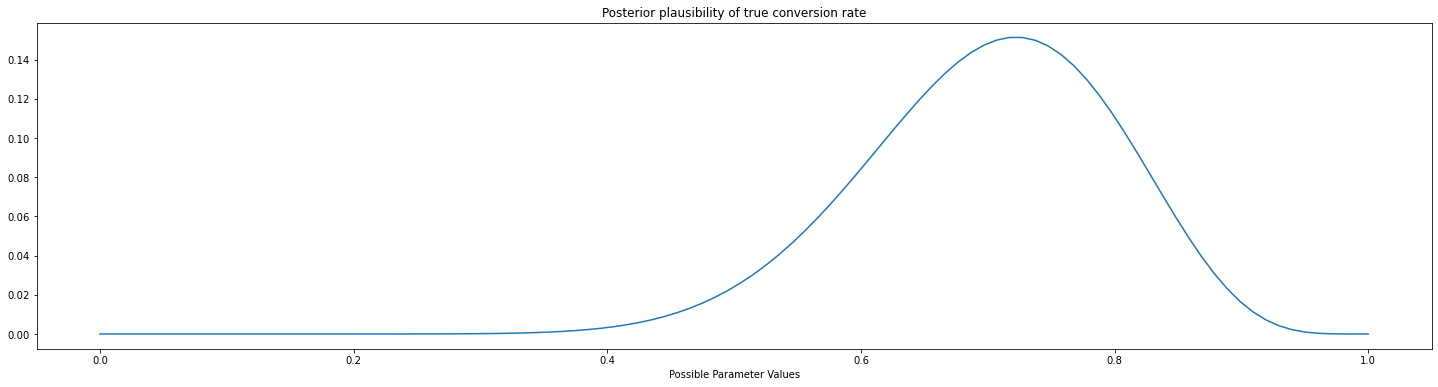

In [7]:
fig, ax = plt.subplots(figsize=(25,6))

ax.plot(possible_p_values, posterior)
ax.set_title("Posterior plausibility of true conversion rate")
ax.set_xlabel("Possible Parameter Values");

# 🔑  The *Bayesian update* process
Compare the three distributions together. Specifically how we 

1. Start a (justified) prior
2. Calculate the likelihood using observed data and model
3. Use all the above to estimate a posterior


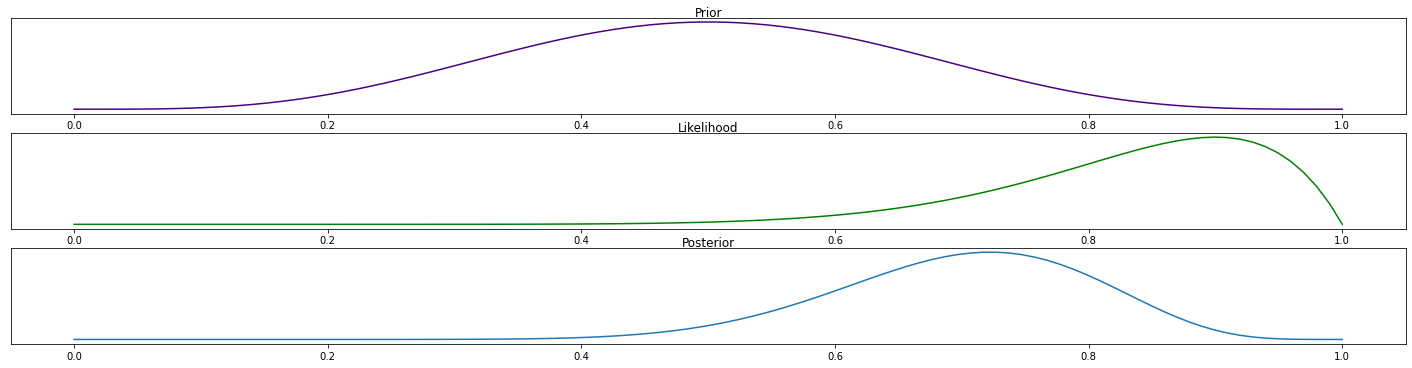

In [8]:
fig, axes = plt.subplots(3,1, figsize=(25,6))

ax = axes[0]
prior = beta.pdf(possible_p_values)
ax.plot(possible_p_values, prior, c="indigo")
ax.set_title("Prior", y=.95)
ax.set_yticks([]);

ax = axes[1]
ax.plot(possible_p_values,likelihood, c="g")
ax.set_title("Likelihood", y=.95)
# ax.set_ylabel("Relative Likelihood of parameter value given data")
ax.set_xlabel("Possible Parameter Values");
ax.set_yticks([])

ax = axes[2]
ax.plot(possible_p_values, posterior)
ax.set_title("Posterior", y=.95)
# ax.set_ylabel("Relative Likelihood of parameter value given data")
ax.set_yticks([]);

# 🙌 Change the prior and data and see the effects
Download this notebook and change the prior and data and see what happens. Try using
* A wide prior
* More observations
* Less observations
* Different level of conversions

# 🤔 Calculating the posterior distribution is easy! What do we need PPLs for?
In this simple case, called a beta binomial model, the posterior is straightforward. There's actually an even easier way than we showed

But once we get to more complex models that include many parameters these simple methods stop working

Think of it like a bicycle, with small short distances and light load a simple bike works just fine. But once you need to go a long distance or carry a heavy load a car is better. Same idea here.

#  MCMC for posterior estimation
In the rest of this course we'll use a sampling based method called Markov Chain Monte Carlo

MCMC is a method that has gained a lot of momentum in the last decade because it 
* Works well on many models relatively automatically
* Is efficient and returns results relatively quickly
* Comes with a good set of diagnostics to guide you

A big job of modern PPLs is to serve as an interface to methods such as MCMC

This will be covered in future lessons.

# Section Recap
* Posterior distributions 
    * allow us to perform *inference* the goal of statistics
    * incorporate the data, the model, and our priors
* Bayesian updating is the process of combining prior, likelihood, data
* Posterior estimation is not always "easy or straightforward"
    * PPLs typically estimate the posterior with a sampling technique called MCMC 

# Bayes Rule Summary
* The three terms we care about in Bayes Rule
  * And the one we don't
* The different types of priors
  * Informative 
  * Uninformative
* How to calculate likelihood given data
* How to calculate a simple posterior